# Analysis of the model parameters estimate I
Here we analyze the model parameters estimate from the chosen model, i.e., model with seed 66. In the model sensitivity analysis, we initialized the algorithm for 50 random inputs and chose the one with highest expected log-likelihood predictive density on full data. 

+ Data visual summary  
+ Fitted model validity: Numerical measure

In [1]:
## call python script to load data and column order
exec(open('data_file.py').read())

# load packages 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import vb_stan as vbfun
figfol = 'mem_plot/'

plt.rcParams.update(plt.rcParamsDefault)

params = {'legend.fontsize': 12,
          'font.weight': 'bold',
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'axes.labelweight': 'bold',
         'xtick.labelsize':12,
         #'figure.figsize': (15,8),
          'figure.dpi': 200,
         'ytick.labelsize':12}
plt.rcParams.update(params)

%matplotlib inline

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


### Data visual summary 
Load input and output data for the analysis.

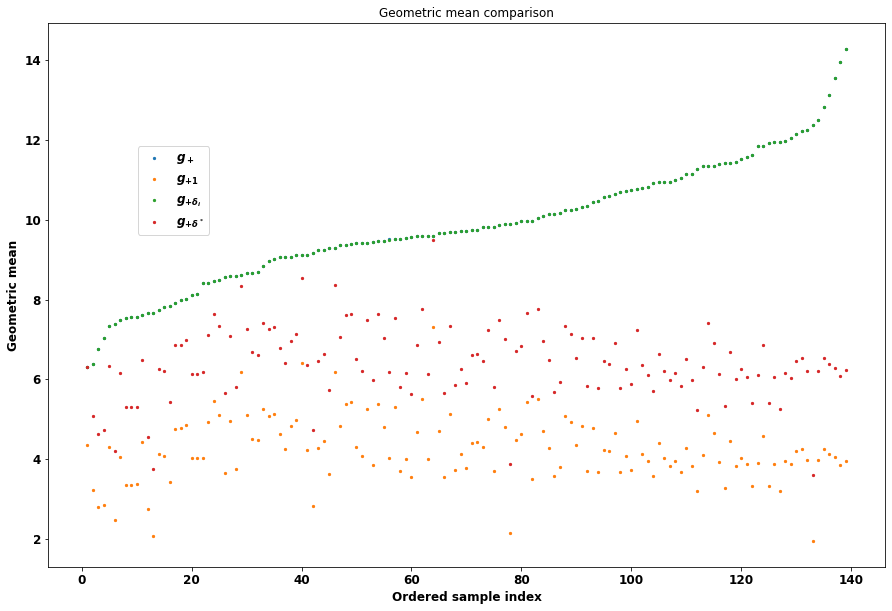

In [2]:
# Plots to compare the geometric mean of the observed outcome data 
def gpfun(a):
    return np.exp(np.mean(np.log(a[a>0])))
T_p = np.apply_along_axis(gpfun,1,Yo)
T_1 = np.exp(np.mean(np.log(Yo.T+1), axis=0))
T_min = np.exp(np.mean(np.log(Yo.T+delta.min()), axis=0))


fnamex = figfol + 'geometric_mean_compare.pdf'
d_index = T_p.argsort()
d_index1 = 1 + np.arange(T_p.shape[0])
fig, ax = plt.subplots( figsize = (15,10))
ax.scatter(d_index1, T_p[d_index], s = 5)
ax.scatter(d_index1, T_1[d_index], s = 5)
ax.scatter(d_index1, T_i[d_index], s = 5)
ax.scatter(d_index1, T_min[d_index], s = 5)
ax.legend([r'$g_+$', r'$g_{+1}$', r'$g_{+\delta_i}$', r'$g_{+\delta^*}$'], bbox_to_anchor=(0.1, 0.6))
ax.set_title('Geometric mean comparison')
ax.set_ylabel('Geometric mean')
ax.set_xlabel('Ordered sample index')
fig.savefig(fnamex)

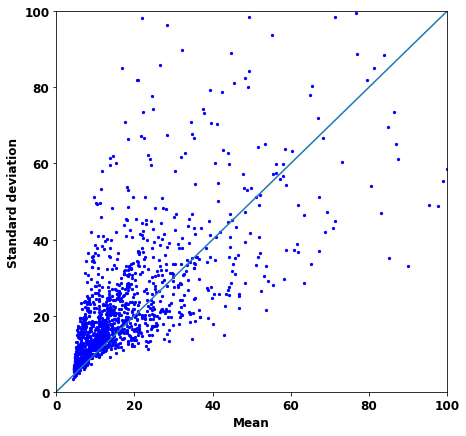

In [3]:
## heatmap of outcome and overdispersion in the data
# Mean and standard deviation of the plot 
a = np.mean(Y, axis = 0)
b = np.std(Y, axis = 0)
fig, ax = plt.subplots( figsize = (7, 7))
ax.scatter(a, b, s = 5, c = 'blue')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel('Mean')
ax.set_ylabel('Standard deviation')
x = np.linspace(0,100)
ax.plot(x, x)


### Fitted model validity: Numerical measure

Here we perform the posterior predictive check to validate the parameters estimate. 

In [4]:
# Call the output from the fitted model:
fname_best = '66_model_nb_cvtest.pkl'
folname = 'MMSens/'
[holdout_mask, llpd, n_test, l,m_seed,sp_mean,\
 sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(open(folname + fname_best, "rb"))

# -------------------------------------------------
# save model output 
fname_ot = folname + str(uid) + '_' + 'model_nb.pkl' 
#with open(fname_o, 'wb') as f:
#    pickle.dump(NB_vb, f)
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)
    
sample_fname = folname + str(uid) + '_' + 'sample_model_nb_cvtest.pkl' 
with open(sample_fname, 'rb') as f:
    [Yte_sample,Yte_cv] = pickle.load(f)
    

In [5]:
## Individual value as test statistics
n,q = Y.shape
Y_ppc1 = np.zeros((n,q))
for i in range(n):
    for j in range(q):
        Y_ppc1[i,j] = np.mean(Yte_sample[:,i,j] <= Y[i,j])
        
## P-valie reported :   0.5221216234559521
np.mean(Y_ppc1)

0.5221216234559521

In [6]:
## Posterior predictive check
parma_sample  = vbfun.vb_extract_sample(results)
parma_sample  =  dict(parma_sample)
# Yte_lpmf = np.zeros((nsample_o, n,q))
# Yte_lpmf = Yte_lpmf.astype(np.float64)
# mu_sample = np.zeros((nsample_o, n,q))
# mu_sample = mu_sample.astype(np.float64)
# for i in range(n):
#     if (i%10) ==0:
#         print(i)
#     for j in range(q):
#         for s_ind in range(nsample_o):
#             mu_sample[s_ind, i,j] =  parma_sample['C0'][s_ind, j] + \
#             np.matmul(X[i,],parma_sample['C_geo'][s_ind,j,:]) + \
#             np.matmul(S[i,],np.matmul(parma_sample['A_s'][s_ind,:,:],parma_sample['L_sp'][s_ind,j,:])) + \
#             np.matmul(Q[i,],np.matmul(parma_sample['A_m'][s_ind,:,:],parma_sample['L_sp'][s_ind,j,:])) + \
#             np.matmul(B[i,],np.matmul(parma_sample['A_b'][s_ind,:,:],parma_sample['L_sp'][s_ind,j,:]));
#             if Yi[i,j] == 1:
#                 temp = copy.copy(Yi[i,:]);temp[j] = 0;
#                 mu_sample[s_ind, i,j] = mu_sample[s_ind,i,j] + np.matmul( \
#                          parma_sample['L_i'][s_ind,j,:], np.matmul(parma_sample['L_sp'][s_ind,:,:].T,temp))/(Bs[i]-1.0);
                                 
#             mu_sample[s_ind,i,j] =  T_i[i]*np.exp(mu_sample[s_ind,i,j]* parma_sample['tau'][s_ind,j])
#             Yte_lpmf[s_ind,i,j] = vbfun.neg_binomial_2_lpmf(Yte_sample[s_ind,i,j],\
#              mu_sample[s_ind,i,j],1/np.sqrt(parma_sample['phi'][s_ind,j]))
            
# # Best model sample log probability mass function 
# pickle.dump(Yte_lpmf, open('BMSample_lpmf.pkl','wb'))
Yte_lpmf = pickle.load(open('BMSample_lpmf.pkl','rb'))

/mnt/home/amishra/jobs/microbiome/embeddings/vb_stan.py:25: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])


In [7]:
## Get mean estimate of the Negative Binomial model 
parma_mean  = dict(vbfun.vb_extract_mean(results))
muest = np.zeros((n,q))
muest1 = np.zeros((n,q))
for i in range(n):
    for j in range(q):
        muest[i,j] =  parma_mean['C0'][j] + \
            np.matmul(X[i,],parma_mean['C_geo'][j,:]) + \
            np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
            np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
            #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])) + \
        if Yi[i,j] == 1:
            temp = copy.copy(Yi[i,:]);temp[j] = 0;
            muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
            muest[i,j] = muest[i,j] + muest1[i,j];
        muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])
            
## Individual value as test statistics
Y_ppc2 = np.zeros((n,q))
for i in range(n):
    for j in range(q):
        Y_ppc2[i,j] = np.nanmean(Yte_lpmf[:,i,j] <= vbfun.neg_binomial_2_lpmf(Y[i,j],\
             muest[i,j],1/np.sqrt(parma_mean['phi'][j])))

## P-valie reported :   0.5934413079115808  
np.nanmean(Y_ppc2)

/mnt/home/amishra/jobs/microbiome/embeddings/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


0.5934413079115808

<font color=blue>**Our analysis suggest that MEM the P value from the posterior predictive check analysis is 0.59. Hence, we fail to reject the hypthesis that our model is different from the true model.** </font>